## Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import yaml
import sys
import matplotlib.pyplot as plt
import sys
import pandas as pd
from settings import (
    SPEED_DATA_PATH,
    WIND_DATA_PATH_INIT,
    WIND_DATA_PATH, 
    GEO_PATH
)
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, SeparableConv1D
from tensorflow.keras.models import Model
import lz4.frame

from sz.SZ3.tools.pysz.pysz import SZ
from compress.sprintz_encode import compress_sprintz, get_sprintz_memory, decompress_sprintz
from compress.bypass import spatial_clustering, geo_sort, get_corr_lists
from compress.general_functions import get_memory_init, get_float_bytes, get_geo_dict, create_geo_plot
from compress.xor_encode import xor_compress_df, get_xor_memory_df, decompress_xor, decompress_xor_df
from compress.lz4_encode import LZ4_compress_df, get_lz4_memory, LZ4_decompress_df
from compress.spatial_lz4 import spatial_clustering_PCA_LZ4, spatial_lz4_decompress
from compress.spatial_xor import spatial_clustering_xor, spatial_XOR_decompress, get_spatial_xor_memory
from compress.spatial_sprintz import spatial_clustering_sprintz, spatial_sprintz_decompress
from compress.sz3_encode import compress_sz3_df, decompress_sz3_df, get_sz3_size
import seaborn as sns
from sklearn.metrics import mean_squared_error

2025-04-08 00:05:46.901478: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Params

In [2]:
table_params = [{
                'selector': 'caption',
                'props': [
                    ('color', 'Blue'),
                    ('font-size', '16pt'),
                    ('font-weight', 'bold'),
                    ('text-align', 'center'),
                    ('caption-side', 'top'),
                    ('padding', '10px')
                ]
            },
            {
                'selector': 'th',
                'props': [('font-size', '14pt')]
            }]

## Data

In [3]:
# int time series
speed_init = pd.read_csv(SPEED_DATA_PATH, parse_dates=[0], index_col=[0])# данные заполненности дорог
speed_init.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2015-08-31 18:22:00 to 2015-09-17 16:24:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2500 non-null   int64
dtypes: int64(1)
memory usage: 39.1 KB


In [4]:
speed_init['index'] = np.arange(speed_init.shape[0])
sensor_data = {}

for i in range(5):
    sensor_data[f'sensor_{i+1}'] = speed_init.loc[speed_init['index'] % 5 == i,
                                             ['value']]['value'].to_list()

df_speed = pd.DataFrame(sensor_data)
print('DataFrame shape:', df_speed.shape)
df_speed.head()

DataFrame shape: (500, 5)


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,90,80,84,94,90
1,91,62,96,75,84
2,86,93,69,88,71
3,74,68,88,71,87
4,82,68,73,69,57


In [5]:
df_speed.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,82.126000,81.538000,81.862000,81.786000,82.222000
std,8.404963,9.247897,8.155488,8.913085,8.983659
min,43.000000,28.000000,53.000000,29.000000,20.000000
25%,77.000000,76.000000,77.000000,76.000000,77.000000
50%,83.000000,82.000000,82.000000,82.000000,83.000000
75%,87.000000,88.000000,87.000000,88.000000,88.000000
max,109.000000,103.000000,106.000000,106.000000,105.000000


In [6]:
df_wind = pd.read_csv(WIND_DATA_PATH)
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_0  5371 non-null   float64
 1   sensor_1  5371 non-null   float64
 2   sensor_2  5371 non-null   float64
 3   sensor_3  5371 non-null   float64
 4   sensor_4  5371 non-null   float64
 5   sensor_5  5371 non-null   float64
dtypes: float64(6)
memory usage: 251.9 KB


In [7]:
# df_speed = df_wind.copy()
# df_speed = df_speed * 100
# df_speed = df_speed.astype(int)

In [8]:
# df_wind_init = pd.read_csv(WIND_DATA_PATH_INIT)
# df_wind_init.info()


Возьмем данные о первых шести ветренных вышек.

In [9]:
# df_wind = df_wind_init[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']]
# df_wind = df_wind.head(10000)

Видим, что данные ненулевые через определенные промежутки времени. Это связано с тем, что отсутствует непрерывность замеров данных. Оставим только те строки, где есть хотя бы одно ненулевое значение.

In [10]:
# Ensure the correct columns are used
# df_wind = df_wind.loc[(
#     df_wind[['AT', 'BE', 'BG', 'CH', 'CZ', 'DE']] != 0).any(axis=1)].reset_index(drop=True)
# df_wind.columns = [f'sensor_{i}' for i in range(df_wind.shape[1])]
# df_wind.info()

In [11]:
#df_wind.to_csv('data/wind_df.csv', index=False) # save test dataframe

## Data analisys

### Распределение

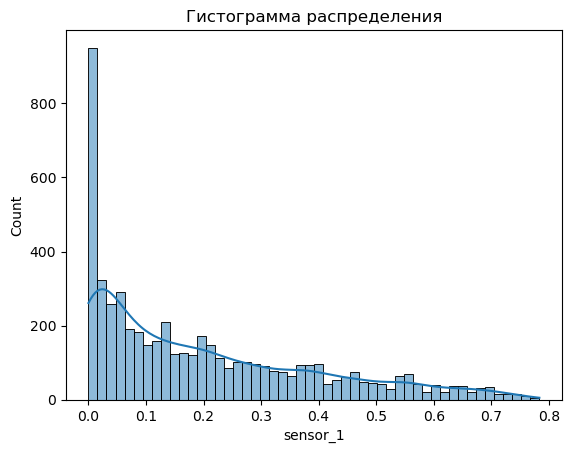

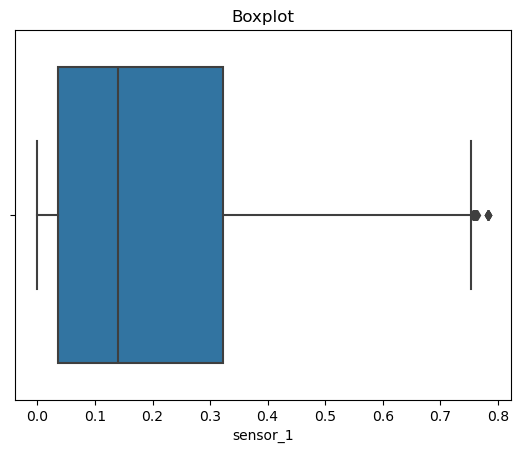

In [12]:
# Гистограмма + KDE
data = df_wind['sensor_1']
sns.histplot(data, kde=True, bins=50)
plt.title("Гистограмма распределения")
plt.show()

# Boxplot
sns.boxplot(x=data)
plt.title("Boxplot")
plt.show()

In [13]:
from scipy.stats import skew, kurtosis

skewness = skew(data)
kurt = kurtosis(data)

print(f"Асимметрия: {skewness:.2f}")
print(f"Эксцесс: {kurt:.2f}")

Асимметрия: 0.95
Эксцесс: -0.05


In [14]:
from scipy.stats import shapiro, normaltest

# Шапиро-Уилк (работает для небольших выборок < 5000)
stat, p = shapiro(data)
print(f"Шапиро-Уилк p-value: {p:.5f}")

# D’Agostino’s K-squared (для больших выборок)
stat, p = normaltest(data)
print(f"D’Agostino p-value: {p:.5f}")

Шапиро-Уилк p-value: 0.00000
D’Agostino p-value: 0.00000


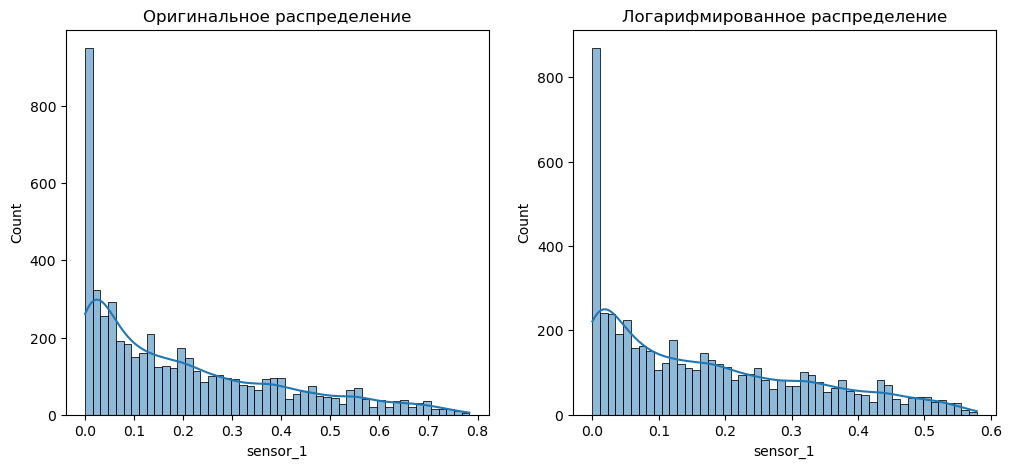

In [15]:
data_log = np.log1p(data)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data, kde=True, bins=50, ax=axes[0])
axes[0].set_title("Оригинальное распределение")

sns.histplot(data_log, kde=True, bins=50, ax=axes[1])
axes[1].set_title("Логарифмированное распределение")

plt.show()

### Шум

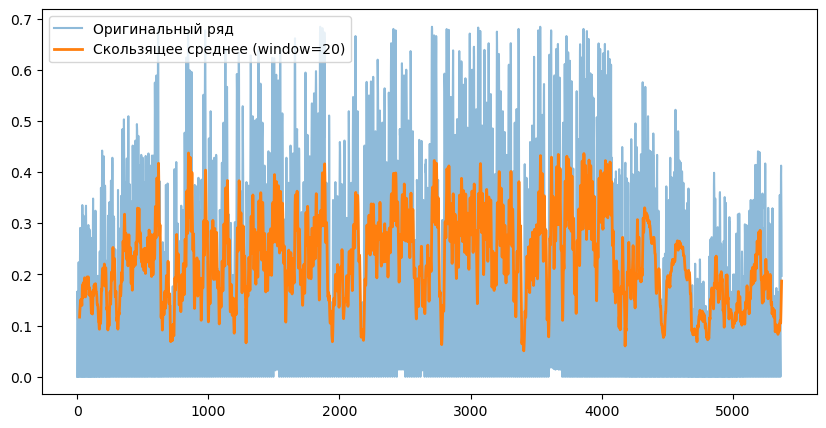

In [16]:
rolling_mean = df_wind.sensor_0.rolling(window=20).mean()

plt.figure(figsize=(10,5))
plt.plot(df_wind.sensor_0.values, label="Оригинальный ряд", alpha=0.5)
plt.plot(rolling_mean, label="Скользящее среднее (window=20)", linewidth=2)
plt.legend()
plt.show()

In [17]:
X = df_wind.sensor_0.values

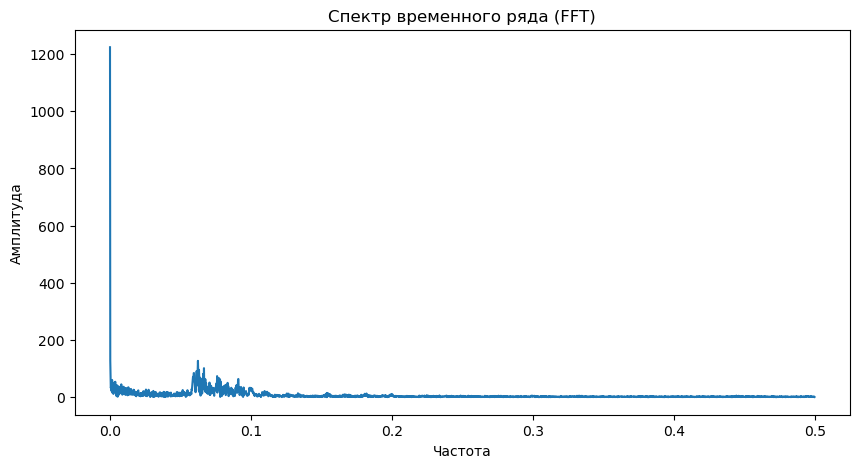

In [18]:
from scipy.fftpack import fft

X_fft = np.abs(fft(X))
freqs = np.fft.fftfreq(len(X))

plt.figure(figsize=(10,5))
plt.plot(freqs[:len(freqs)//2], X_fft[:len(X_fft)//2])
plt.title("Спектр временного ряда (FFT)")
plt.xlabel("Частота")
plt.ylabel("Амплитуда")
plt.show()

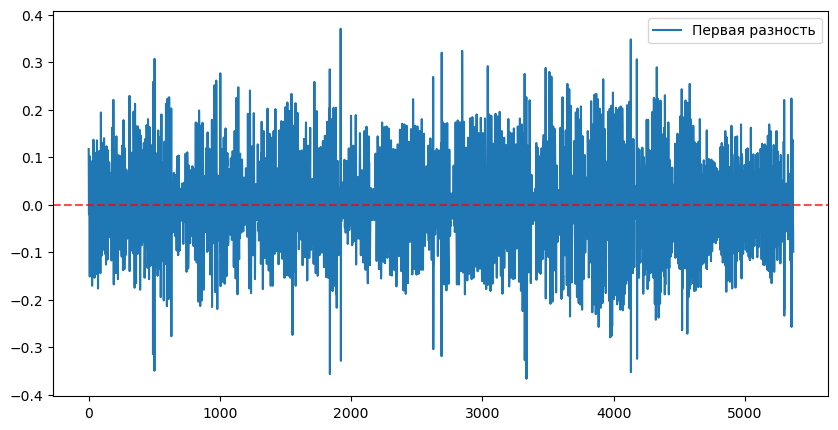

In [19]:
X_diff = np.diff(X)

plt.figure(figsize=(10,5))
plt.plot(X_diff, label="Первая разность")
plt.axhline(0, color='r', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [20]:
from scipy.stats import entropy

hist, _ = np.histogram(X, bins=50)
ent = entropy(hist)

print(f"Энтропия ряда: {ent:.3f}")

Энтропия ряда: 3.685


In [21]:
import pywt

wavelet = 'haar'
coeffs = pywt.wavedec(X, wavelet, level=3)

# Оценим долю энергии в каждом уровне разложения
energy_levels = [np.sum(np.abs(c)**2) for c in coeffs]

print("Энергия коэффициентов на каждом уровне разложения:", energy_levels)

Энергия коэффициентов на каждом уровне разложения: [356.04758554508646, 65.73701276035354, 27.73028362734523, 9.927217631002883]


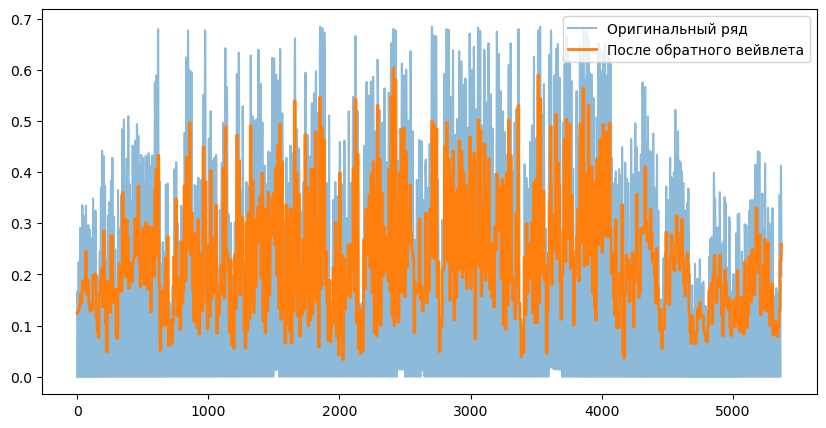

In [22]:
coeffs_filtered = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
X_restored = pywt.waverec(coeffs_filtered, wavelet)

plt.figure(figsize=(10,5))
plt.plot(X, label="Оригинальный ряд", alpha=0.5)
plt.plot(X_restored, label="После обратного вейвлета", linewidth=2)
plt.legend()
plt.show()

## Create or download geo_dict

In [23]:
# # create for speed
# def get_geo_dict(df):
#     # make geo data
#     sen_num = df.shape[1]
#     x_y = []
#     for i in range(sen_num):
#         x_y.append([rn.uniform(.0, 6.0), rn.uniform(.0, 6.0)])
#         print(f'sensor_{i}:', x_y[i])
#     plt.grid(True)
#     for i in range(len(x_y)):
#         plt.plot(x_y[i][0], x_y[i][1], 'o', label = i)
#         plt.legend(loc = 'best', fancybox = True, shadow = True)
#     plt.plot(3*np.ones(300), np.arange(0, 6, 0.02))
#     plt.plot(np.arange(0, 6, 0.02), 3*np.ones(300))
#     geo_dict = dict(zip(df.columns, x_y))
#     print(geo_dict)
#     return dict(zip(df.columns, x_y))

sensor_0: [0.6036334163435397, 4.649413887777019]
sensor_1: [3.3188570516567912, 1.4409135325778701]
sensor_2: [4.255540055414804, 0.6692592419120635]
sensor_3: [1.8516539989528338, 3.1958776453800826]
sensor_4: [2.6732805901256906, 0.1483305284113512]


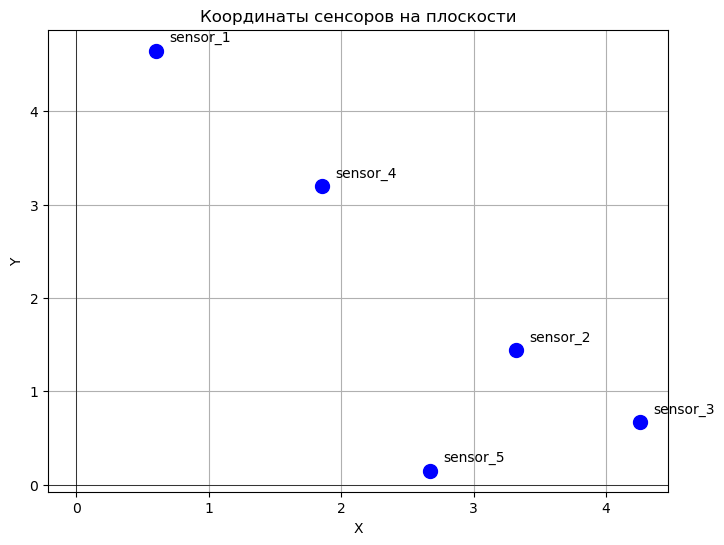

In [24]:
speed_geo_dict = get_geo_dict(df_speed)
create_geo_plot(speed_geo_dict)

In [25]:
# #for best clustering
# d = {'sensor_0': [1.1, 4.2],
#      'sensor_1': [3.2, 1.9],
#      'sensor_2': [3.8, 2.6],
#      'sensor_3': [0.51, 4.9],
#      'sensor_4': [1.2, 3.1],
#      'sensor_5': [2.12, 3.9],
#      'sensor_6': [0.8, 1.2],
#      'sensor_7': [1.3, 0.9],}
# spatial_clustering(df_wind, d)

In [26]:
# create geo dict for wind dataset
# wind_geo_dict = get_geo_dict(df_wind)
# create_geo_plot(wind_geo_dict)

In [27]:
# print('Clusters for Emhires dataset:')
# spatial_clustering(df_wind, wind_geo_dict)

{'sensor_0': [1.1, 4.2], 'sensor_1': [4.3, 1.9], 'sensor_2': [5.1, 2.6], 'sensor_3': [0.5, 5.0], 'sensor_4': [1.2, 3.8], 'sensor_5': [2.12, 3.9]}


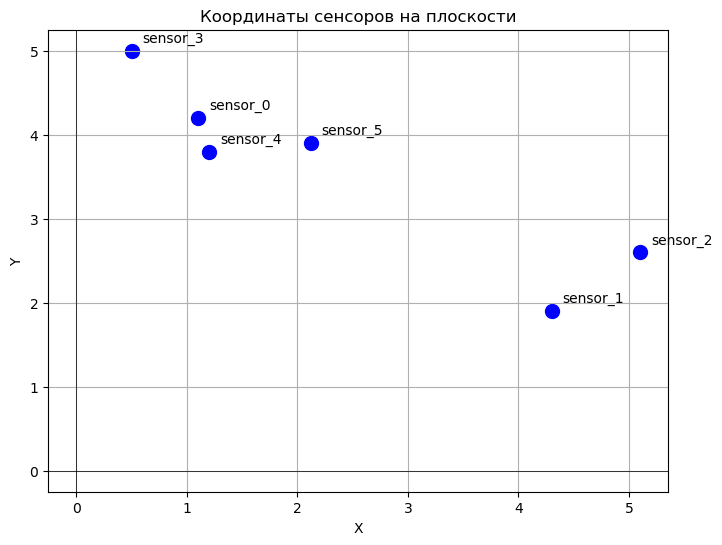

In [28]:
with open(GEO_PATH / 'wind_geo_dict.yaml', 'r') as file:
    wind_geo_dict = yaml.safe_load(file)

print(wind_geo_dict)
create_geo_plot(wind_geo_dict)

In [29]:
print('Clusters for Emhires dataset:')
spatial_clustering(df_wind, wind_geo_dict)

Clusters for Emhires dataset:


{'sensor_0': ['sensor_0', 'sensor_4', 'sensor_3', 'sensor_5'],
 'sensor_1': ['sensor_1'],
 'sensor_2': ['sensor_2']}

## Sprintz

In [30]:
df = df_wind * 100
df = df.astype(int)
df = df[['sensor_0', 'sensor_3', 
         'sensor_4', 'sensor_5', ]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5371 entries, 0 to 5370
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sensor_0  5371 non-null   int64
 1   sensor_3  5371 non-null   int64
 2   sensor_4  5371 non-null   int64
 3   sensor_5  5371 non-null   int64
dtypes: int64(4)
memory usage: 168.0 KB


In [31]:
df_speed.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,82.126000,81.538000,81.862000,81.786000,82.222000
std,8.404963,9.247897,8.155488,8.913085,8.983659
min,43.000000,28.000000,53.000000,29.000000,20.000000
25%,77.000000,76.000000,77.000000,76.000000,77.000000
50%,83.000000,82.000000,82.000000,82.000000,83.000000
75%,87.000000,88.000000,87.000000,88.000000,88.000000
max,109.000000,103.000000,106.000000,106.000000,105.000000


In [32]:
df.describe()

,sensor_0,sensor_3,sensor_4,sensor_5
count,5371.000000,5371.000000,5371.000000,5371.000000
mean,22.345746,22.193819,20.626885,16.579780
std,18.257546,18.558063,20.355336,15.782994
min,0.000000,0.000000,0.000000,0.000000
25%,7.000000,6.000000,3.000000,3.000000
50%,18.000000,17.000000,14.000000,12.000000
75%,37.000000,36.000000,34.000000,27.000000
max,68.000000,70.000000,79.000000,65.000000


In [33]:
speed_sprintz_res = compress_sprintz(df=df, chunk_size=8)

In [34]:
# Check for equals decodind and original data
decode_res = decompress_sprintz(speed_sprintz_res, num_cols = 4, chunk_size=7)
decode_res.columns = df.columns
print('Check for decode:', df.equals(decode_res))

Check for decode: True


In [35]:
decode_res

,sensor_0,sensor_3,sensor_4,sensor_5
0,0,0,0,0
1,11,6,6,1
2,16,15,12,6
3,14,22,13,10
4,16,28,20,15
...,...,...,...,...
5366,41,19,24,9
5367,38,23,20,9
5368,34,21,16,8
5369,29,15,13,7


In [36]:
df

,sensor_0,sensor_3,sensor_4,sensor_5
0,0,0,0,0
1,11,6,6,1
2,16,15,12,6
3,14,22,13,10
4,16,28,20,15
...,...,...,...,...
5366,41,19,24,9
5367,38,23,20,9
5368,34,21,16,8
5369,29,15,13,7


In [37]:
(df.sensor_5 == decode_res.sensor_5).all()

True

In [38]:
get_memory_init(df_speed)
get_sprintz_memory(speed_sprintz_res)

Размер исходных данных: 2179 байт 

Память сжатых Sprintz данных: 119518 бит
Память сжатых Sprintz данных: 14939 байт 



## XOR

In [39]:
compressed_df = xor_compress_df(df_wind)
decompressed_df = decompress_xor_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [40]:
get_xor_memory_df(df_wind, compressed_df)

Размер исходных данных: 257808 байт 

Размер сжатых XOR данных: 249461 байт
Коэффициент сжатия: 1.033


## LZ4

In [41]:
compressed_df = LZ4_compress_df(df_wind)
decompressed_df = LZ4_decompress_df(compressed_df)
print('Check for decode:', decompressed_df.equals(df_wind))

Check for decode: True


In [42]:
get_lz4_memory(df_wind, compressed_df)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 191643 байт 

Коэффициент сжатия: 1.345


## Spatial + XOR

In [43]:
#todo solve problems where dif
df = df_wind.round(15)

In [44]:
res = spatial_clustering_xor(df, wind_geo_dict)
decompressed_df = spatial_XOR_decompress(res)
print('Check for decode:', decompressed_df.equals(df))

Check for decode: True


In [45]:
get_spatial_xor_memory(df, res)

Размер исходных данных: 257808 байт 

Размер сжатых данных: 255656.625 байт 

Коэффициент сжатия: 1.008


## Spatial + Sprintz

In [46]:
df = df_wind*100
df = df.astype(int)

In [47]:
res = spatial_clustering_sprintz(df.copy(), wind_geo_dict, 0.7)

['sensor_0', 'sensor_4', 'sensor_3', 'sensor_5']


In [48]:
clust_dict = spatial_clustering(
    df, wind_geo_dict, 0.7)
decode_res = spatial_sprintz_decompress(res,
                                        clust_dict)

In [49]:
clust_dict = spatial_clustering(
    df, wind_geo_dict, 0.7)
decode_res = spatial_sprintz_decompress(res,
                                        clust_dict)
print('Check for decode:', df.equals(decode_res))

Check for decode: False


In [50]:
def get_lz4_memory(compressed_df):
    memory = 0
    for col in compressed_df:
        memory += len(compressed_df[col])
    print(f'Размер сжатых данных: {memory} байт', '\n')

In [51]:
get_memory_init(df)
total = 0
res_keys = res.keys()
for k in res_keys:
    if len(res[k]) == 1:
        total += len(res[k][0])
    else:
        infb = 0
        for r in res[k]:
            infb+=len(''.join(r[0]))
            infb+=len(r[1])
        infb = infb//8
        total += infb
print(f'Размер сжатых данных: {total} байт', '\n')

Размер исходных данных: 16428 байт 

Размер сжатых данных: 42420 байт 



## Spatial + PCA + LZ4

In [52]:
def rmse(df1, df2):
    return round(np.sqrt(np.median((df1 - df2)**2)), 3)

def mse(df1, df2):
    return round(np.median((df1 - df2)**2), 3)

def mae(df1, df2):
    return ((df1 - df2) ** 2).mean().mean()

def total_error(df1, df2):
    return (df1 - df2).abs().sum().sum()

def column_error(df1, df2):
    return (df1 - df2).abs().sum(axis=0)

In [53]:
res = spatial_clustering_PCA_LZ4(df_wind, wind_geo_dict)

In [54]:
res

{'sensor_0': [b'\x04"M\x18H@\xb0O\x01\x00\x00\x00\x00\x00c\x0e\xf3\x00\x00\xf2\x83\x19\x85h\xd1(\xcb\xda\xbf\x8d\\\x02d\xf1!\x9f?\x99\x15\xac\xf1\xb9\xc8\xd1\xbft\xb2\xdc\x8b8\xf0\x98?\x1b\x06\x08\x17x+\xc4\xbfT\x83\t\xc9*\x9cI\xbf\xad\xa4 \xfdJ\xa5\xbc\xbf\xbc\x07\xdf\xcf\x9ef\xa9\xbf`\xc7\xb7\xe7\x9e\x90\x86\xbf\xb0\xc9\xad\x0f\x01d\xa8\xbf[-\xa8<\xa3\xc0\x94\xbf~F\xa6\xb6\x0e`\xab\xbf\xaf\xdaw\x93 \x80\xb9\xbf\x8f\x02\xc2\xde\xb4\xc6\xae\xbf0\xda\x0f\xb2+A\xc6\xbf\x91)\x8a\x96\x14\x92\xae\xbf\xe9\xce\xb7G/\xc5\xcf\xbf6\x8fgg\xe5\x02\xaa\xbf\xed\x84\x90\x00"\x84f\x90\x00\xfdp\x96t~y[\xff\xd2\xbf\x9d\xa4\xeb\xdbU\x00\x94?\xaa\xfa\xd9\x1fa\xd8\xc2\xbf\xe7\x85<\x8c\xec\xa7\xf7\xbeG\xd1\x9b\xfb\xa9I\xb2\xbf\x9a\xba\xce\x13\xd3\x93\x8e\xbfX\xc39\xcf\x87S\xbb\xbf\xbd\x1a\x80}\xb7\xf7\xc4\xbf\xef\x13\xf5\x84J\xbd\xba\xbf\xdb\xbe\xc7]g\xba\xc8\xbf\xeb\x0b\x9ao\x17\x05\xc0\xbf\xcb\xb0/n\x8fd\xc9\xbf\xab\x00\x98e\x93\xfd\xc6\xbfb\xfb\xca8zx\xc2\xbfL}\xfcb\xd6\x1b\xcf\xbf\xbak@\xcb\x9b\xa8\xad\

In [55]:
len(res['sensor_0'][0]+res['sensor_0'][1])

81173

In [56]:
clusters = spatial_clustering(df_wind, wind_geo_dict)
dec_res = spatial_lz4_decompress(res, clusters)

6


In [57]:
print('RMSE:', rmse(df_wind, dec_res))
print('MSE:', mse(df_wind, dec_res))
print('MAE:', mae(df_wind, dec_res))
print('Total error:', total_error(df_wind, dec_res))
print('Column error:\n', column_error(df_wind, dec_res))

RMSE: 0.005
MSE: 0.0
MAE: 0.0010792084202583803
Total error: 541.2244023274866
Column error:
 sensor_0    191.142023
sensor_1      0.000000
sensor_2      0.000000
sensor_3     61.528244
sensor_4     86.944538
sensor_5    201.609598
dtype: float64


In [58]:
get_float_bytes(df_wind)
total_bytes = sum(sys.getsizeof(v) for k in res.keys() for v in res[k])
print('Сжатое байт:', total_bytes)

Размер исходных данных: 257808 байт 

Сжатое байт: 148935


## SZ3

In [59]:
init_size = get_float_bytes(df_wind)
data_enc = compress_sz3_df(df_wind)
print('Размер сжатых данных(байт):', get_sz3_size(data_enc))
data = df_wind.values.transpose()
shape = [d.shape for d in data]
type = data[0].dtype
data_dec = decompress_sz3_df(data_enc, shape, type)

Размер исходных данных: 257808 байт 

Размер сжатых данных(байт): 12635


In [60]:
print('MSE', round(mean_squared_error(data, data_dec), 6))

MSE 0.000271


In [61]:
data = df_wind.values.transpose()

In [62]:
lib_extension = {
    "darwin": "libSZ3c.dylib",  # macOS
    "win32": "SZ3c.dll",  # Windows
}.get(sys.platform, "libSZ3c.so")  # Linux (по умолчанию)
lib_extension
sz = SZ(f"/usr/local/lib/{lib_extension}")
# сжатие всего кластера сразу
data_cmpr, cmpr_ratio = sz.compress(data, eb_mode=0, eb_pwr=0, eb_rel=0, eb_abs=0.03)
print(f"Compression ratio: {cmpr_ratio}")

Compression ratio: 22.3733402759698


In [63]:
size_in_bytes = data_cmpr.nbytes
print(f"Объем массива: {size_in_bytes} байт")
data_dec = sz.decompress(data_cmpr, data.shape, data.dtype)
print('MSE', round(mean_squared_error(data, data_dec), 6))

Объем массива: 11523 байт
MSE 0.000263


## SZ + Conv

In [64]:
#Выделяем в датафрейм кластер
df = df_wind[['sensor_0', 'sensor_3', 'sensor_4', 'sensor_5']].copy()

In [65]:
#Обучаем NN
main_sensor = df.iloc[:, 0].values.astype(np.float32)
dependent_sensors = df.iloc[:, 1:].values.astype(np.float32)
X = main_sensor.reshape(-1, 1)
Y = dependent_sensors
# Гиперпараметры
window_size = 64
X_windows = []
Y_targets = []
output_dim = Y.shape[1]
for i in range(len(X) - window_size):
    X_windows.append(X[i:i+window_size])
    Y_targets.append(Y[i+window_size]) 

X_windows = np.array(X_windows).reshape(-1, window_size, 1)
Y_targets = np.array(Y_targets).reshape(-1, output_dim)

X_windows = np.array(X_windows).reshape(-1, window_size, 1)
Y_targets = np.array(Y_targets).reshape(-1, output_dim)
output_dim = Y.shape[1]

inputs = Input(shape=(window_size, 1))
x = SeparableConv1D(2, kernel_size=3,
                    activation='selu',
                    padding='same')(inputs)  # Глубинная свёртка
x = Flatten()(x)
x = Dense(4, activation='selu')(x)  
outputs = Dense(output_dim, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')

model.fit(X_windows, Y_targets, epochs=50, batch_size=64, verbose=1)

preds = model.predict(X_windows)
for i in range(output_dim):
    rmse = mean_squared_error(Y_targets[:, i], preds[:, i])
    print(f"RMSE sen_{i+3}: {rmse:.6f}")

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0627
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0344
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119
Epoch 13/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116
Epoch 14/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112
Epoch 15/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110
Epoch 16/50
83/83 ━

In [66]:
# Сжимаем модель с lz4
model.export("saved_model")  
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()
with open("models/model.tflite", "wb") as f:
    f.write(tflite_model)
with open("models/model.tflite", "rb") as f:
    tflite_bytes = f.read()
    compressed_model = lz4.frame.compress(tflite_bytes)
with open("models/model.tflite.lz4", "wb") as f:
    f.write(compressed_model)

print(f"Размер модели после сжатия: {len(compressed_model)} байт")

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  5621217616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5621217792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5621218848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5621218320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5621218496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5621217968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5621218672: TensorSpec(shape=(), dtype=tf.resource, name=None)
Размер модели после сжатия: 5366 байт


W0000 00:00:1744059995.452473 10609602 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1744059995.452521 10609602 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2025-04-08 00:06:35.453313: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: saved_model
2025-04-08 00:06:35.455057: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-08 00:06:35.455121: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: saved_model
2025-04-08 00:06:35.476360: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-04-08 00:06:35.477833: I tensorflow/cc/saved_model/loader.cc:234] Restoring SavedModel bundle.
2025-04-08 00:06:35.534577: I tensorflow/cc/saved_model/loader.cc:218] Running initialization op on SavedModel bundle at path: saved_model
2025-04-08 00:06:35.554963: I tensorflow/cc/saved_model/loader.cc:317] SavedMo

In [67]:
# Распаковка модели обратно
with open("models/model.tflite.lz4", "rb") as f:
    compressed_data = f.read()
    decompressed_tflite = lz4.frame.decompress(compressed_data)
interpreter = tf.lite.Interpreter(model_content=decompressed_tflite)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [68]:
#Предсказания после распаковки
restored_Y = []
for i in range(len(X_windows)):
    input_tensor = X_windows[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    restored_Y.append(output[0])
restored_Y = np.array(restored_Y)

In [69]:
for i in range(output_dim):
    rmse = mean_squared_error(Y[window_size:, i], restored_Y[:, i])
    print(f"MSE sen_{i+3}: {rmse:.6f}")

MSE sen_3: 0.009464
MSE sen_4: 0.009845
MSE sen_5: 0.006997


In [70]:
#Сжатие главного сенсора и некластеризованных
other_sensors = df_wind[['sensor_0', 'sensor_1', 'sensor_2']].iloc[:5307].values.transpose()
mem = 0
data_dec = []
for d in other_sensors:
    data_cmpr, cmpr_ratio = sz.compress(d, eb_mode=0, eb_pwr=0, eb_rel=0, eb_abs=0.03)
    data_dec.append(sz.decompress(data_cmpr, d.shape, d.dtype))
    mem += data_cmpr.nbytes
print('Размер сжатых (байт):', mem)

Размер сжатых (байт): 6472


In [71]:
print('Весь размер сжатых данных (байт):', mem+len(compressed_model))

Весь размер сжатых данных (байт): 11838


In [72]:
y_restored = restored_Y.transpose()
y_targets = Y_targets.transpose()
data_dec = np.array(data_dec)
dec = np.concatenate([y_restored, data_dec])
orig = np.concatenate([y_targets, other_sensors])
print('MSE:', mean_squared_error(dec, orig))

MSE: 0.0045187847017966335
